## 1. Context and Assumptions

This analysis uses historical U.S. traffic accident records (2016–2023) to study accident severity patterns across multiple cities. The dataset is observational and was collected from heterogeneous reporting sources, implying non-uniform data quality across regions and time.

The objective of this project is not to maximize in-sample predictive performance, but to evaluate how well severity prediction models trained on a set of cities generalize to a geographically unseen city.

Key assumptions and constraints:
- Severity labels are assumed to be correct but potentially noisy.
- Weather and road condition variables may contain sensor and reporting errors.
- Some features may not be available at prediction time and must be excluded to avoid leakage.
- Distributional differences across cities are expected and treated as a core modeling challenge.

This notebook focuses on validating data integrity and identifying risks that could invalidate downstream modeling.

## 2. Load and Schema Inspection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

### 2.1. Load Data from CSV

In [2]:
raw = pd.read_csv("../data/raw/US_Accidents_March23.csv")
raw.shape

(7728394, 46)

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

### 2.2. Column Role Classification

The dataset contains 46 columns that we could classify as follows:
- Identifiers: `ID`, `Description`, `Zipcode`, `Airport_Code`
- Location hierarchy (high cardinality): `Street`, `City`, `County`, `State`, `Timezone`, `Country`
- Temporal (leakage-sensitive): `Start_Time`, `End_Time`, `Weather_Timestamp`, Twilight columns
- Continuous physical signals: Temperature, Wind, Visibility, Distance, etc.
- Categorical weather: `Weather_Condition`, `Wind_Direction`
- Binary infrastructure indicators: Crossing, Traffic Signal, Junction, etc.

### 2.3. Check for duplicates

In [4]:
n_duplicated_id = raw.duplicated(subset=["ID"]).sum()
n_duplicated_rep = raw.duplicated(subset=list(raw.columns[1:])).sum()

In [5]:
print(f"There are {n_duplicated_id} (%{100*n_duplicated_id/raw.shape[0]:.2f}) duplicated ID.")
print(f"There are {n_duplicated_rep} (%{100*n_duplicated_rep/raw.shape[0]:.2f}) duplicated accident reports (ignoring ID column).")

There are 0 (%0.00) duplicated ID.
There are 102338 (%1.32) duplicated accident reports (ignoring ID column).


In [6]:
duplicates_cols = list(raw.columns)
duplicates_cols.remove("ID")

Although there are no duplicated IDs, there are 102338 duplicated records when ignoring the `ID` column. These duplicates are removed.

In [7]:
df = raw.drop_duplicates(subset=duplicates_cols).copy()

### 2.4. Check for null values
We have 12 columns (26%) with over 0.5% missing values. This is a preliminary overview; detailed missingness analysis is deferred to Section 3.

In [8]:
(100 * df.isnull().sum() / df.shape[0] > 0.5).sum()

12

### 2.5. Check data types

In [9]:
df["Start_Time"] = pd.to_datetime(raw["Start_Time"], format='ISO8601')
df["End_Time"] = pd.to_datetime(raw["End_Time"], format='ISO8601')
df["Weather_Timestamp"] = pd.to_datetime(raw["Weather_Timestamp"], format='ISO8601')

### 2.6. Cardinality inspection

In [10]:
df[["Street", "City", "County", "State", "Timezone", 
     "Country", "Weather_Condition"]].nunique()

Street               336306
City                  13678
County                 1871
State                    49
Timezone                  4
Country                   1
Weather_Condition       144
dtype: int64

#### Street Type Cardinality

`Street` exhibits extremely high cardinality (>300k unique values), making it unsuitable for direct encoding. If retained, it would require aggregation or transformation (e.g., extraction of street type) during feature engineering.

#### Cities Cardinality

In [11]:
df["CityState"] = df["City"] + ", " + df["State"]

cities_counts = df["CityState"].value_counts().sort_values(ascending=False)

top_30_cities = list(cities_counts[:30].index)
# Add Boston to the list for comparison
top_30_cities.append("Boston, MA")

In [12]:
(cities_counts[cities_counts.index.isin(top_30_cities)]
 .sort_values(ascending=False))

CityState
Miami, FL            183632
Houston, TX          168208
Los Angeles, CA      154955
Charlotte, NC        136851
Dallas, TX           129343
Orlando, FL          108666
Austin, TX            95772
Raleigh, NC           85348
Nashville, TN         72037
Baton Rouge, LA       70757
Atlanta, GA           67169
Sacramento, CA        65490
San Diego, CA         54895
Phoenix, AZ           53091
Minneapolis, MN       50907
Oklahoma City, OK     46040
Jacksonville, FL      41022
Richmond, VA          40995
Tucson, AZ            37987
San Antonio, TX       37106
Saint Paul, MN        36716
Seattle, WA           36262
Greenville, SC        35472
Columbia, SC          34761
San Jose, CA          34349
Portland, OR          34252
Indianapolis, IN      32931
Chicago, IL           31925
Tampa, FL             30907
Denver, CO            29328
Boston, MA             4813
Name: count, dtype: int64

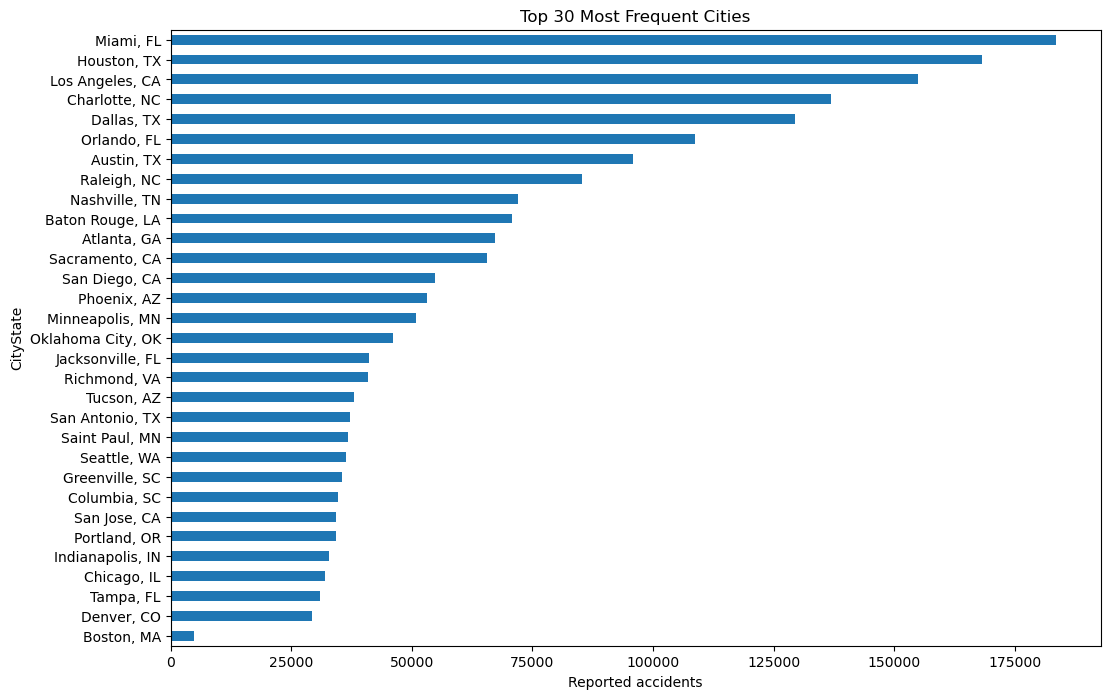

In [13]:
plt.figure(figsize=(12,8))
(cities_counts[cities_counts.index.isin(top_30_cities)]
 .sort_values(ascending=True)
 .plot(kind="barh")
 .set_title("Top 30 Most Frequent Cities"))
plt.xlabel("Reported accidents")
plt.show()

City Frequency Distributions

In [14]:
df["CityState"].value_counts().describe()

count     20323.000000
mean        375.230330
std        3333.980932
min           1.000000
25%           5.000000
50%          22.000000
75%         117.000000
max      183632.000000
Name: count, dtype: float64

City frequency is highly imbalanced—some cities only have one reported accident while others reach 183632. Small cities are retained for now and will be handled explicitly during split design and evaluation.

Boston is included for reference, as it will later serve as a geographic holdout city during evaluation.

#### Severity Cardinality

In [15]:
df["Severity"].unique()

array([3, 2, 1, 4], dtype=int64)

Severity values are restricted to the expected discrete set {1, 2, 3, 4} with no missing labels. Distributional analysis is deferred to Section 6.

### 2.7. Early Leakage Risk Identification
Several columns contain information that is only available after the accident impact has fully materialized and are therefore flagged as leakage-prone:
- `End_Time`: Recorded when traffic impact was dismissed; post-event by definition.
- `Distance(mi)`: Measures road extent affected by the accident. This is essentially severity expressed spatially.
- `End_Lat`, `End_Lng`: End point are only known after traffic impact resolves. Spatially correlated with `Distance(mi)`.
- `Description`: Natural language description written after the accident; potentially encoding severity cues.

`Weather_Timestamp` alignment with `Start_Time` requires validation to avoid future information leakage.

All flagged columns are excluded from modeling at this stage but retained for analysis and validation.

### 2.8. Modeling Implications
High-cardinality location fields (Street, City, Zipcode) are excluded from modeling to prevent memorization of geography. Temporal variables are retained only in forms that reflect information available at accident onset.

## 3. Missingness Audit
This section analyzes the structure and patterns of missing data across features, cities, and time. The goal is to determine whether missingness is random or systematic, and to assess its potential impact on cross-city generalization.

We are essentially asking three main questions:
1. What is missing?
2. Where is it missing?
3. Is missingness correlated with geography or time?

### 3.1. Missingness by Column

In [16]:
missing_pct = 100 * df.isna().mean()
missing_pct = missing_pct.sort_values(ascending=False)

In [17]:
missing_pct[missing_pct > 0.5].round(2)

End_Lat              44.59
End_Lng              44.59
Precipitation(in)    28.76
Wind_Chill(F)        26.10
Wind_Speed(mph)       7.43
Visibility(mi)        2.28
Wind_Direction        2.25
Humidity(%)           2.24
Weather_Condition     2.23
Temperature(F)        2.11
Pressure(in)          1.81
Weather_Timestamp     1.54
dtype: float64

End location coordinates (`End_Lat`, `End_Lng`) exhibit high missingness (~45%), consistent with post-event reporting. Weather-related features show moderate to high missingness, particularly precipitation and wind chill, indicating potential sensor or reporting gaps that may vary across space and time.

In [18]:
cols_focus = [
    "Weather_Timestamp", "Temperature(F)", "Wind_Chill(F)", 
    "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
    "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition"
]

### 3.2. Missingness by City
Missingness is evaluated for high-volume cities for diagnostic purposes only. This analysis does not imply any filtering or selection decisions at this stage.

In [19]:
missing_by_city = (
    df[df["CityState"].isin(top_30_cities)]
        .groupby("CityState")[cols_focus]
        .apply(lambda x: 100 * x.isna().mean())
)

# Order by city sample size
city_freq = (
    df[df["CityState"].isin(top_30_cities)]
        .groupby("CityState").size()
        .sort_values(ascending=False)
)

missing_by_city = missing_by_city.loc[city_freq.index]

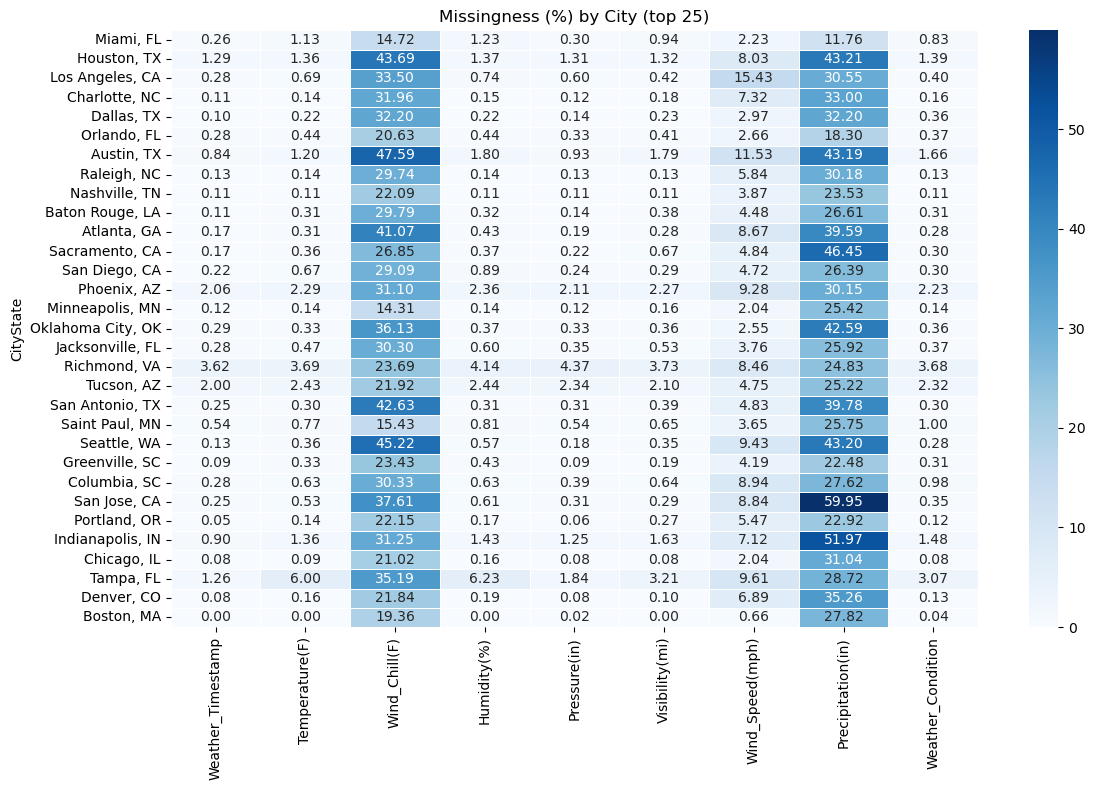

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    missing_by_city, 
    cmap="Blues", 
    linewidths=0.5, 
    annot=True, 
    fmt=".2f"
)
plt.title("Missingness (%) by City (top 25)")
plt.tight_layout()
plt.show()

Weather feature missingness varies substantially across cities. In particular, precipitation and wind chill exhibit high missingness in several cities, while core meteorological variables (temperature, pressure, humidity) remain largely complete. This suggests non-uniform sensor coverage and reporting practices that may affect cross-city generalization.

In [21]:
bins = [0, 1_000, 10_000, 50_000, cities_counts.max()]
labels = ["Very Small", "Small", "Medium", "Large"]

In [22]:
city_sizes = pd.cut(
    cities_counts, 
    bins=bins, 
    labels=labels, 
    include_lowest=True
).to_frame("City_Size").reset_index()

In [23]:
df = df.merge(city_sizes, left_on="CityState", right_on="CityState")

In [24]:
missing_by_city_size = (
    df.groupby("City_Size", observed=False)[cols_focus]
        .apply(lambda x: 100 * x.isna().mean())
)

In [25]:
missing_by_city_size.round(2).T

City_Size,Very Small,Small,Medium,Large
Weather_Timestamp,2.18,2.27,0.65,0.42
Temperature(F),2.81,3.02,1.12,0.67
Wind_Chill(F),20.39,26.85,27.02,30.27
Humidity(%),3.02,3.16,1.21,0.75
Pressure(in),2.46,2.56,1.04,0.48
Visibility(mi),3.25,3.23,1.11,0.66
Wind_Speed(mph),7.59,8.71,5.90,6.53
Precipitation(in),24.19,30.38,29.53,30.17
Weather_Condition,3.20,3.20,1.03,0.63


Aggregating cities by reporting volume reveals a systematic relationship between city size and data availability. Smaller cities exhibit higher missingness across most weather-related features. However, precipitation and wind chill remain highly incomplete even in large cities, indicating global feature instability rather than purely small-city effects.

### 3.3. Missingness by Year

In [26]:
df["Year"] = df["Start_Time"].dt.year

In [27]:
missing_by_year = (
    df.groupby("Year")[cols_focus]
        .apply(lambda x: 100 * x.isna().mean())
)

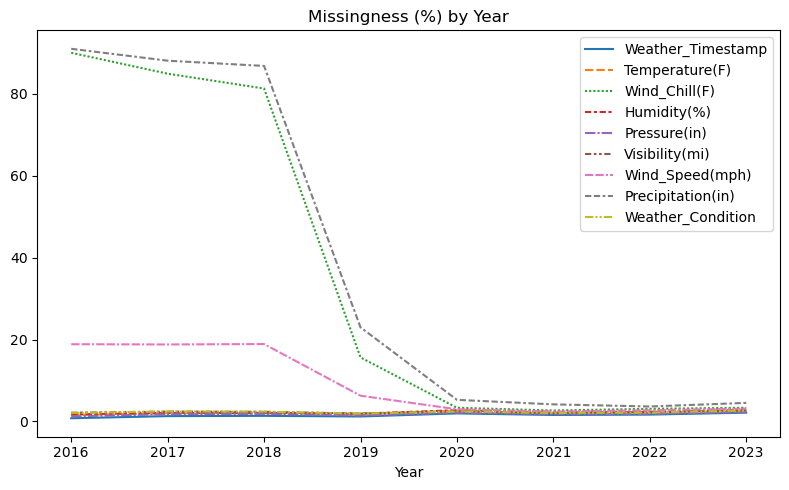

In [28]:
plt.figure(figsize=(8,5))
sns.lineplot(missing_by_year.round(2))
plt.title("Missingness (%) by Year")
plt.tight_layout()
plt.show()

Weather data completeness improves sharply after 2018-2019, particularly for wind chill, wind speed, and precipitation. This suggests changes in data sourcing or sensor coverage over time, implying that models trained on earlier years may experience feature availability drift when applied to more recent data.

### 3.4. Missingness by Source

In [29]:
(100 * df["Source"].value_counts() / df.shape[0]).round(2)

Source
Source1    55.41
Source2    43.32
Source3     1.28
Name: count, dtype: float64

In [30]:
missing_by_source = (
    df.groupby("Source")[cols_focus]
        .apply(lambda x: 100 * x.isna().mean())
)

missing_by_source.round(2).T

Source,Source1,Source2,Source3
Weather_Timestamp,1.83,1.18,1.42
Temperature(F),2.43,1.68,2.12
Wind_Chill(F),12.54,43.57,22.01
Humidity(%),2.58,1.80,2.23
Pressure(in),2.10,1.44,1.69
Visibility(mi),2.56,1.92,2.02
Wind_Speed(mph),4.82,10.81,6.41
Precipitation(in),14.58,46.98,26.23
Weather_Condition,2.49,1.91,1.98


Missingness patterns vary substantially by data source, particularly for precipitation and wind-related features. `Source2` exhibits markedly higher missingness in wind chill (\~44%) and precipitation (\~47%) compared to `Source1` and `Source3`. This suggests that data availability differences are partly driven by upstream provider characteristics rather than purely geographic factors, reinforcing the need to account for source-level heterogeneity during modeling.

### 3.5. Missingness by Severity class

In [31]:
missing_by_severity = (
    df.groupby("Severity")[cols_focus]
        .apply(lambda x: 100 * x.isna().mean())
)
missing_by_severity.round(2).T

Severity,1,2,3,4
Weather_Timestamp,0.98,1.56,1.33,2.49
Temperature(F),1.66,2.10,2.00,3.23
Wind_Chill(F),3.32,21.96,46.18,29.21
Humidity(%),1.87,2.23,2.10,3.40
Pressure(in),1.19,1.80,1.72,2.87
Visibility(mi),1.39,2.23,2.34,3.63
Wind_Speed(mph),2.02,6.51,11.56,10.28
Precipitation(in),5.84,24.43,49.37,34.15
Weather_Condition,1.41,2.17,2.33,3.63


Missingness increases with severity for several weather-related features, particularly precipitation and wind chill, suggesting that reporting intensity or data availability may differ by accident severity.

### 3.6. Modeling Implications
Systematic differences in weather-related missingness across cities suggest that imputation must be handled carefully to avoid amplifying regional artifacts. Features with extreme or structurally inconsistent missingness will be excluded or simplified prior to modeling.

## 4. Physical Plausibility Checks
This section audits numeric and temporal features for values that violate physical or logical constraints. The goal is to identify sensor, ingestion, or reporting errors that could destabilize modeling and harm cross-city generalization.

### 4.1. Numeric Range Validation

In [32]:
numeric_cols_ranges = {
    "Temperature(F)": (-40, 120),
    "Wind_Chill(F)": (-60, 80),
    "Humidity(%)": (0, 100),
    "Pressure(in)": (28, 32),
    "Visibility(mi)": (0, 20),
    "Wind_Speed(mph)": (0, 60),
    "Precipitation(in)": (0, 10),
    "Distance(mi)": (0, 100)
}

Ranges are intentionally conservative to flag extreme or potentially unstable values rather than to define absolute physical impossibility.

In [33]:
violations = {}

for col, (lo, hi) in numeric_cols_ranges.items():
    mask = (df[col] < lo) | (df[col] > hi)
    violations[col] = {
        "count": mask.sum(),
        "pct": 100 * mask.mean()
    }

numeric_violations = (
    pd.DataFrame(violations).T.sort_values("pct", ascending=False)
)

In [34]:
numeric_violations.round(5)

,count,pct
Wind_Chill(F),883629.0,11.58735
Pressure(in),373009.0,4.89140
Visibility(mi),9967.0,0.13070
Wind_Speed(mph),233.0,0.00306
Temperature(F),86.0,0.00113
Distance(mi),86.0,0.00113
Precipitation(in),60.0,0.00079
Humidity(%),0.0,0.00000


Several numeric features contain values that exceed physically plausible ranges. These likely reflect sensor errors, aggregation artifacts, or ingestion issues rather than rare real-world events.

In [35]:
df["Distance(mi)"].describe()

count    7.625806e+06
mean     5.584823e-01
std      1.776926e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.700000e-02
75%      4.580000e-01
max      4.417500e+02
Name: Distance(mi), dtype: float64

`Distance(mi)` exhibits both extreme values and conceptual dependence on accident impact, reinforcing its exclusion from modeling as both physically unstable and leakage-prone.

### 4.2 Temporal Consistency Checks

This section verifies that time-related variables follow logical chronological order and produce reasonable accident durations. These checks help detect reporting inconsistencies and potential modeling risks.

#### End time after start time

In [36]:
invalid_time_order = df["End_Time"] < df["Start_Time"]
invalid_time_order.mean() * 100

0.0

No timestamp inconsistencies identified.

#### Accident duration sanity

In [37]:
duration_hours = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 3600
duration_hours.describe(percentiles=[0.95, 0.99, 0.999])

count    7.625806e+06
mean     6.864138e+00
std      2.151065e+02
min      2.027778e-02
50%      1.244444e+00
95%      6.000000e+00
99%      1.310833e+01
99.9%    8.420509e+01
max      4.688232e+04
dtype: float64

In [38]:
print(
    f"count:\t{(duration_hours > 24).sum()}\n"
    f"pct:\t%{(duration_hours > 24).mean() * 100:.2f}"
)

count:	32653
pct:	%0.43


While most accident durations are short, a non-trivial tail extends beyond reasonable limits, suggesting delayed incident resolution updates or reporting artifacts rather than prolonged physical events.

### 4.3. Modeling Implocations
Rows containing physically implausible values are removed to prevent noise-driven learning. Features derived from `End_Time` or duration are excluded to avoid post-event leakage.

## 5. Target Variable Audit (Severity)
This section audits the target variable (`Severity`) to assess class balance, temporal stability, and geographic consistency. The objective is to determine whether severity labels are comparable across cities and over time, and to identify risks that may affect cross-city generalization.

### 5.1. Overall Severity Distribution

In [39]:
df["Severity"].value_counts(normalize=True).sort_index().mul(100).round(2)

Severity
1     0.86
2    79.51
3    16.98
4     2.64
Name: proportion, dtype: float64

The dataset is heavily dominated by Severity 2 incidents (~80%), with Severity 1 and 4 representing minority classes. This strong imbalance requires class-aware evaluation and careful handling during modeling.

### 5.2. Severity Distribution by City

In [40]:
sev_by_city = (
    df[df["CityState"].isin(top_30_cities)]
        .groupby("CityState")["Severity"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

In [41]:
sev_by_city.round(2)

Severity,1,2,3,4
CityState,,,,
"Atlanta, GA",0.23,49.52,46.11,4.14
"Austin, TX",0.75,89.95,8.90,0.40
"Baton Rouge, LA",1.51,88.91,9.23,0.35
"Boston, MA",2.26,68.88,28.28,0.58
"Charlotte, NC",1.83,92.54,5.21,0.42
"Chicago, IL",0.88,40.28,55.73,3.11
"Columbia, SC",0.79,79.18,18.99,1.03
"Dallas, TX",0.77,72.87,25.50,0.86
"Denver, CO",1.24,56.96,39.28,2.52


Severity proportions vary substantially across cities. Some cities show high concentrations of Severity 3 incidents, while others are overwhelmingly dominated by Severity 2. This indicates that severity labeling is not geographically uniform and may reflect regional reporting practices, traffic patterns, or upstream data-source differences.

In [42]:
sev_by_size = (
    df.groupby("City_Size", observed=True)["Severity"]
      .value_counts(normalize=True)
      .mul(100)
      .unstack()
)

In [43]:
sev_by_size.round(2)

Severity,1,2,3,4
City_Size,,,,
Very Small,0.66,78.59,14.06,6.70
Small,0.79,79.86,17.53,1.82
Medium,1.21,76.71,20.66,1.41
Large,0.85,82.96,15.33,0.86


Severity distributions also vary by city size. Very small cities exhibit a higher proportion of Severity 4 incidents relative to larger cities, suggesting possible reporting bias or structural differences in incident capture across reporting scales.

### 5.3. Severity Distribution by Year

In [44]:
sev_by_year = (
    df.groupby("Year")["Severity"]
      .value_counts(normalize=True)
      .mul(100)
      .unstack()
)

In [45]:
sev_by_year.round(2)

Severity,1,2,3,4
Year,,,,
2016,0.05,65.71,30.74,3.49
2017,0.04,64.37,32.23,3.36
2018,0.03,64.31,32.79,2.87
2019,0.02,72.12,24.93,2.92
2020,2.41,78.48,16.52,2.59
2021,0.01,88.46,9.54,1.99
2022,2.16,90.93,4.44,2.47
2023,NaN,97.13,NaN,2.87


A pronounced temporal drift is observed. Severity 2 increases from \~65% in 2016–2018 to over 90% by 2022 and 97% in 2023, while Severity 3 declines sharply over the same period.

In [46]:
df.loc[df["Year"] == 2023, "Severity"].value_counts()

Severity
2    238752
4      7061
Name: count, dtype: int64

In 2023, only Severity 2 and 4 are present, with Severity 1 and 3 absent.

This structural break suggests a change in labeling or data ingestion rather than a purely behavioral shift in accident severity. As a result, multi-class modeling across the full time span would violate the assumption of label stability.

### 5.4. Collapsing Severity Classes
To improve temporal consistency, severity is collapsed into binary impact categories:
- Low impact -> Severity 1 & 2
- High impact -> Severity 3 & 4

In [47]:
def collapse_severity(sev):
    if sev == 1 or sev == 2:
        return "Low"
    return "High"

df["Severity2"] = df["Severity"].apply(collapse_severity)

Overall distribution

In [48]:
(100 * df["Severity2"].value_counts() / df.shape[0]).round(2)

Severity2
Low     80.37
High    19.63
Name: count, dtype: float64

Temporal distribution

In [49]:
sev2_by_year = (
    df.groupby("Year")["Severity2"]
      .value_counts(normalize=True)
      .mul(100)
      .unstack()
)
sev2_by_year.round(2)

Severity2,High,Low
Year,,
2016,34.24,65.76
2017,35.60,64.40
2018,35.66,64.34
2019,27.86,72.14
2020,19.11,80.89
2021,11.53,88.47
2022,6.91,93.09
2023,2.87,97.13


High-impact incidents decline from \~35% in 2016–2018 to under 3% in 2023. Although collapsing classes mitigates instability between Severity 2 and 3, substantial temporal drift remains.

### 5.5. Modeling Implications
Due to pronounced temporal drift in severity labeling after 2018, the modeling dataset is restricted to 2016–2018. Severity is collapsed into a binary target (Low vs High impact) to ensure temporal stability and consistent class representation.

## 6. Exploratory Analysis
This EDA is performed only on the modeling dataset:
- Years restricted to 2016–2018 (stable labeling regime)
- Binary target (Low vs High impact)
- Boston excluded (held out for evaluation)

The objective is to identify features that exhibit plausible and stable relationships with accident severity and are suitable for cross-city generalization.

### 6.1. Variable Exclusion
Certain variables were excluded from further analysis due to limited interpretability, redundancy, or instability across cities.
- `Wind_Chill` is strongly correlated with temperature and therefore redundant. - Humidity, pressure, and wind direction lack a clear mechanistic link to accident severity and exhibit weak or inconsistent relationships across regions.
- Raw geographic coordinates were excluded to avoid location memorization that would undermine cross-city generalization.

The feature set was intentionally constrained to signals with plausible causal mechanisms and stable behavior across cities.

### 6.2. Time Period Consideration
The dataset was restricted to 2016–2018 due to significant temporal drift in severity labels after 2018, including a structural break in 2023. Limiting the analysis to the most stable period helps isolate geographic generalization effects and avoids confounding from changes in labeling practices.

In [50]:
eda_df = df[(df["Year"] <= 2018) & (df["CityState"] != "Boston, MA")].copy()
eda_df.shape

(2016112, 50)

Rows containing values outside physically plausible ranges (e.g., extreme wind speeds or temperatures) are dropped because they likely reflect sensor or ingestion errors rather than real-world conditions. Retaining such records would introduce noise and potentially bias model learning with artifacts that do not generalize.

In [51]:
for col, (lo, hi) in numeric_cols_ranges.items():
    mask = (eda_df[col].isnull()) | ((eda_df[col] >= lo) & (eda_df[col] <= hi))
    eda_df = eda_df[mask]

In [52]:
eda_df["Severity2"].value_counts(normalize=True).mul(100).round(2)

Severity2
Low     64.67
High    35.33
Name: proportion, dtype: float64

### 6.1. Temporal Signals

#### Severity by Hour

In [53]:
eda_df["Hour"] = eda_df["Start_Time"].dt.hour

In [54]:
sev_by_hour = (
    eda_df.groupby("Hour")["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

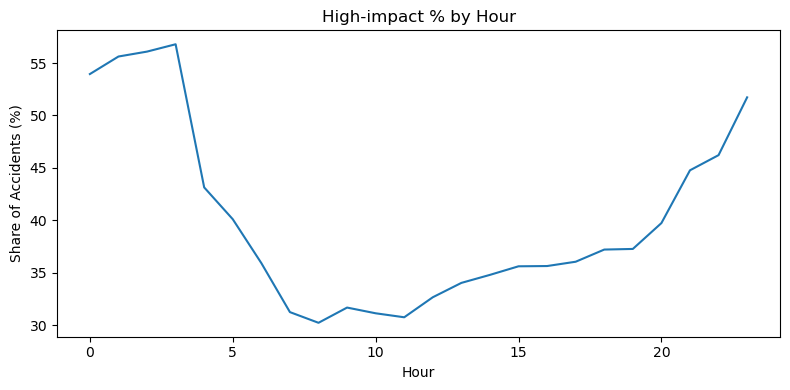

In [55]:
plt.figure(figsize=(8,4))
sev_by_hour["High"].plot(title="High-impact % by Hour")
plt.ylabel("Share of Accidents (%)")
plt.tight_layout()
plt.show()

High-impact incidents are substantially more frequent during late-night hours (00:00–03:00), exceeding 50%, compared to \~30–35% during daytime. This suggests nighttime conditions are strongly associated with accident severity and represent a robust temporal signal.

#### Severity by Month

In [56]:
eda_df["Month"] = eda_df["Start_Time"].dt.month

In [57]:
sev_by_month = (
    eda_df.groupby("Month")["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

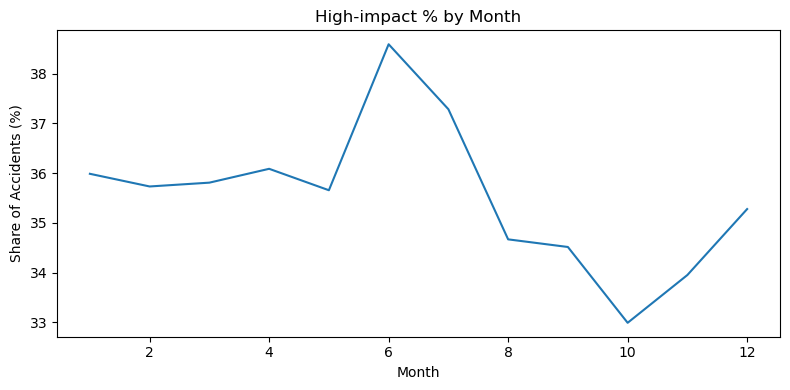

In [58]:
plt.figure(figsize=(8,4))
sev_by_month["High"].plot(title="High-impact % by Month")
plt.ylabel("Share of Accidents (%)")
plt.tight_layout()
plt.show()

Monthly variation in high-impact rates is modest within the 2016–2018 period, indicating limited seasonal signal once temporal drift is controlled. Month is therefore unlikely to be a primary driver of cross-city severity differences.

#### Severity by Day/Night

In [59]:
eda_df["Is_Night"] = eda_df["Sunrise_Sunset"] == "Night"

In [60]:
sev_by_day_night = (
    eda_df.groupby("Is_Night")["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

In [61]:
sev_by_day_night.round(2)

Severity2,High,Low
Is_Night,,
False,33.29,66.71
True,41.13,58.87


Nighttime accidents exhibit a materially higher proportion of high-impact outcomes compared to daytime accidents (41% vs 33%), reinforcing the strength of temporal visibility-related effects.

#### Severity by Weekend

In [62]:
eda_df["Is_Weekend"] = eda_df["Start_Time"].dt.dayofweek >= 5

Distribution of weekend accident reports

In [63]:
eda_df["Is_Weekend"].value_counts(normalize=True).mul(100).round(2)

Is_Weekend
False    90.12
True      9.88
Name: proportion, dtype: float64

In [64]:
sev_by_weekend = (
    eda_df.groupby("Is_Weekend")["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

In [65]:
sev_by_weekend.round(2)

Severity2,High,Low
Is_Weekend,,
False,33.04,66.96
True,56.17,43.83


Weekend accidents show a markedly higher high-impact proportion relative to weekdays. Since the weekend sample is small (\~10%), this may be inflated.

#### Severity by Weekend x Night (Interaction Check)

In [66]:
eda_df["Weekend_Night"] = (
    eda_df["Is_Weekend"].astype(str) + "_" +
    eda_df["Is_Night"].astype(str)
)

sev_interaction = (
    eda_df
        .groupby(["Is_Weekend", "Is_Night"])["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

In [67]:
sev_interaction.round(2)

Severity2             High    Low
Is_Weekend Is_Night              
False      False     31.12  68.88
           True      38.70  61.30
True       False     54.92  45.08
           True      58.86  41.14

Weekend exhibits a strong independent association with higher severity even after controlling for nighttime conditions. High-impact rates increase substantially during weekends in both daytime and nighttime strata, indicating that the weekend effect is not merely a proxy for night-related risk.

### 6.2. Weather Signals

#### Severity by Precipitation (in)

In [68]:
# We Define explicit thresholds
# None: 0
# Light: <= 0.1 inches (Typical NWS standard for total hourly)
# Moderate: <= 0.3 inches (Typical NWS standard for total hourly)
# Heavy: > 0.3 inches
bins = [-0.01, 0.0001, 0.1, 0.3, np.inf]
labels = ["None", "Low", "Moderate", "Heavy"]

eda_df["Rain_Bucket"] = pd.cut(
    eda_df["Precipitation(in)"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

sev_by_rain = (
    eda_df.groupby("Rain_Bucket", observed=True)["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

In [69]:
sev_by_rain.round(2)

Severity2,High,Low
Rain_Bucket,,
None,36.81,63.19
Low,38.68,61.32
Moderate,43.11,56.89
Heavy,43.97,56.03


High-impact rates remain relatively stable across precipitation intensity buckets, suggesting that rainfall alone does not strongly differentiate severity within the stable modeling period.

#### Severity by Visibility (mi)

In [70]:
bins = [-0.01, 1, 3, 6, np.inf]
labels = ["Very Low", "Low", "Moderate", "Clear"]

eda_df["Visibility_Bucket"] = pd.cut(
    eda_df["Visibility(mi)"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

sev_by_visibility = (
    eda_df.groupby("Visibility_Bucket", observed=True)["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

In [71]:
sev_by_visibility.round(2)

Severity2,High,Low
Visibility_Bucket,,
Very Low,36.70,63.30
Low,38.12,61.88
Moderate,37.00,63.00
Clear,34.86,65.14


Reduced visibility is associated with a modest increase in high-impact incidents, though the effect size is moderate relative to temporal signals.

#### Severity by `Weather_Condition`

In [72]:
def group_weather(cond):
    if pd.isna(cond):
        return "Unknown"
    
    cond = cond.lower()
    
    if "rain" in cond or "drizzle" in cond:
        return "Rain"
    if "snow" in cond or "sleet" in cond:
        return "Snow"
    if "fog" in cond or "mist" in cond:
        return "Fog"
    if "storm" in cond or "thunder" in cond:
        return "Storm"
    if "clear" in cond:
        return "Clear"
    if "cloud" in cond:
        return "Cloudy"
    return "Other"

In [73]:
eda_df["Weather_Group"] = eda_df["Weather_Condition"].apply(group_weather)

Distribution of weather condition groups

In [74]:
(eda_df["Weather_Group"].value_counts() / eda_df.shape[0]).mul(100).round(2)

Weather_Group
Clear      36.92
Cloudy     33.06
Other      18.09
Rain        7.11
Unknown     2.37
Snow        1.48
Fog         0.74
Storm       0.22
Name: count, dtype: float64

In [75]:
sev_by_weather_cond = (
    eda_df.groupby("Weather_Group", observed=True)["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
)

In [76]:
sev_by_weather_cond.round(2)

Severity2,High,Low
Weather_Group,,
Clear,33.77,66.23
Cloudy,35.23,64.77
Fog,31.25,68.75
Other,35.63,64.37
Rain,39.07,60.93
Snow,44.23,55.77
Storm,38.87,61.13
Unknown,42.77,57.23


Snow and storm conditions exhibit higher proportions of high-impact incidents compared to clear weather. However, these categories represent a small fraction of observations and should be interpreted cautiously.

### 6.3. Infrastructure Signals

In [77]:
infra_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction",
    "No_Exit", "Railway", "Roundabout", "Station", "Stop",
    "Traffic_Calming", "Traffic_Signal", "Turning_Loop"
]

sev_by_infra = {}

for col in infra_cols:
    sev_by_infra[col] = (
        eda_df.groupby(col)["Severity2"]
           .value_counts(normalize=True)
           .mul(100)
           .unstack()["High"]
    ).round(2)

In [78]:
pd.DataFrame(sev_by_infra).T

,False,True
Amenity,35.74,7.41
Bump,35.34,10.76
Crossing,39.04,10.82
Give_Way,35.40,23.62
Junction,34.31,45.67
No_Exit,35.37,17.59
Railway,35.43,24.97
Roundabout,35.33,8.96
Station,35.89,14.71
Stop,36.09,9.21


Infrastructure-related features display heterogeneous relationships with severity. Certain road context indicators appear strongly associated with high-impact incidents.

The presence of a junction is associated with a substantial increase in high-impact incidents. Conversely, accidents occurring near traffic signals exhibit lower high-impact proportions, suggesting that signalized intersections may mitigate severity through speed control.

### 6.4 Cross-City Signal Stability Check
This subsection evaluates whether the strongest observed relationships with severity remain directionally consistent across geographically diverse cities. We focus on `Is_Night`, `Junction`, and `Traffic_Signal` because they exhibit the largest effect sizes and clear mechanistic interpretations, making them the most plausible candidates for stable cross-city generalization.

In [79]:
cities_verify = [
    "Atlanta, GA",
    "Dallas, TX",
    "Minneapolis, MN",
    "Portland, OR",
    "Philadelphia, PA",
    "Sacramento, CA",
]

verify_df = eda_df[eda_df["CityState"].isin(cities_verify)].copy()

#### Night Effect by City

In [105]:
verify_df["Is_Night"].value_counts(normalize=True).mul(100).round(2)

Is_Night
False    72.74
True     27.26
Name: proportion, dtype: float64

In [80]:
night_effect = (
    verify_df
    .groupby(["CityState", "Is_Night"])["Severity2"]
    .value_counts(normalize=True)
    .mul(100)
    .unstack()
    .reset_index()
)
night_true = night_effect[night_effect["Is_Night"] == True]
night_false = night_effect[night_effect["Is_Night"] == False]

In [81]:
night_true = (
    night_true[["CityState", "High"]]
    .sort_values("High", ascending=False)
    .round(2)
    .set_index("CityState")
    .rename(columns={"High": "High (True)"})
)

night_false = (
    night_false[["CityState", "High"]]
    .sort_values("High", ascending=False)
    .round(2)
    .set_index("CityState")
    .rename(columns={"High": "High (False)"})
)

In [82]:
pd.merge(night_true, night_false, left_index=True, right_index=True)

Severity2,High (True),High (False)
CityState,,
"Atlanta, GA",71.65,63.55
"Minneapolis, MN",55.83,55.65
"Philadelphia, PA",55.25,52.79
"Dallas, TX",39.56,35.30
"Sacramento, CA",31.43,25.00
"Portland, OR",26.15,24.31


The nighttime effect is directionally consistent across cities, with higher proportions of high-impact incidents occurring at night. However, effect magnitude varies substantially, indicating that baseline severity rates differ across regions even when temporal patterns remain stable.

#### Junction Effect by City

In [104]:
verify_df["Junction"].value_counts(normalize=True).mul(100).round(2)

Junction
False    88.78
True     11.22
Name: proportion, dtype: float64

In [83]:
junction_effect = (
    verify_df
    .groupby(["CityState", "Junction"])["Severity2"]
    .value_counts(normalize=True)
    .mul(100)
    .unstack()
    .reset_index()
)
junction_true = junction_effect[junction_effect["Junction"] == True]
junction_false = junction_effect[junction_effect["Junction"] == False]

In [84]:
junction_true = (
    junction_true[["CityState", "High"]]
    .sort_values("High", ascending=False)
    .round(2)
    .set_index("CityState")
    .rename(columns={"High": "High (True)"})
)

junction_false = (
    junction_false[["CityState", "High"]]
    .sort_values("High", ascending=False)
    .round(2)
    .set_index("CityState")
    .rename(columns={"High": "High (False)"})
)

In [85]:
pd.merge(junction_true, junction_false, left_index=True, right_index=True)

Severity2,High (True),High (False)
CityState,,
"Atlanta, GA",64.28,65.76
"Dallas, TX",52.99,35.18
"Minneapolis, MN",48.23,57.96
"Portland, OR",35.13,23.65
"Sacramento, CA",29.00,26.23
"Philadelphia, PA",27.66,55.82


The junction effect is not directionally stable across cities, with several regions exhibiting reversed relationships. This suggests that junction-related severity patterns are context-dependent and may reflect local infrastructure or reporting differences rather than invariant mechanisms.

#### Traffic Signal Effect by City

In [103]:
verify_df["Traffic_Signal"].value_counts(normalize=True).mul(100).round(2)

Traffic_Signal
False    79.14
True     20.86
Name: proportion, dtype: float64

In [86]:
signal_effect = (
    verify_df.groupby(["CityState", "Traffic_Signal"])["Severity2"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack()
        .reset_index()
)

signal_true = signal_effect[signal_effect["Traffic_Signal"] == True]
signal_false = signal_effect[signal_effect["Traffic_Signal"] == False]

In [87]:
signal_true = (
    signal_true[["CityState", "High"]]
    .sort_values("High", ascending=False)
    .round(2)
    .set_index("CityState")
    .rename(columns={"High": "High (True)"})
)

signal_false = (
    signal_false[["CityState", "High"]]
    .sort_values("High", ascending=False)
    .round(2)
    .set_index("CityState")
    .rename(columns={"High": "High (False)"})
)

In [88]:
pd.merge(signal_true, signal_false, left_index=True, right_index=True)

Severity2,High (True),High (False)
CityState,,
"Minneapolis, MN",75.96,54.57
"Philadelphia, PA",45.96,56.98
"Atlanta, GA",28.78,72.16
"Dallas, TX",16.91,46.29
"Portland, OR",12.23,27.67
"Sacramento, CA",3.02,29.13


The presence of traffic signals is associated with lower high-impact rates in most cities, consistent with speed-regulation mechanisms. However, at least one city exhibits a reversed pattern, indicating that signal effects are generally but not universally stable across regions.

Cross-city stability analysis reveals that temporal signals (nighttime) are directionally robust, while certain infrastructure features exhibit regional variability. These findings highlight substantial geographic heterogeneity in severity patterns and reinforce the importance of evaluating model generalization on an unseen city.

### 6.5. Modeling Implications
Only features demonstrating interpretable mechanisms and directional stability across diverse cities are retained for modeling. Infrastructure signals exhibiting inconsistent cross-city effects are excluded to improve transfer robustness.

### 7. Audit Summary & Modeling Implications

#### Key Findings
- Severity labeling exhibits substantial temporal drift after 2018; modeling is restricted to 2016–2018 to preserve label stability.
- Severity base rates vary considerably across cities, reinforcing the need for city-based holdout evaluation.
- Nighttime conditions show a directionally consistent association with higher severity across cities, though effect magnitudes vary.
- Traffic signal presence is generally associated with lower severity, with mostly stable directional effects.
- Junction effects are inconsistent across cities and therefore unsuitable for transfer-focused modeling.
- Rain and snow conditions are associated with elevated severity, with moderate monotonic patterns observed for precipitation intensity.
- Several infrastructure indicators (Amenity, Bump, Roundabout, Stop, etc.) exhibit protective effects but are likely redundant low-speed urban proxies.

#### Final Modeling Dataset Scope
- Years: 2016–2018 (stable labeling regime)
- Target: Binary Severity (Low: 1–2, High: 3–4)
- Training: Multi-city dataset
- Evaluation: Boston held out for geographic generalization testing

#### Final Candidate Feature Set
Temporal
- `Hour` or `Is_Night` (we retain only one night indicator)
- `Is_Weekend`

Weather
- `Rain_Bucket` (monotonic severity increase observed)
- `Weather_Group` (Snow, Rain, Storm effects)
- Optional: `Visibility_Bucket` (moderate but consistent signal)

Infrastructure
- `Traffic_Signal`

#### Excluded Variables and Rationale

- High-cardinality geographic fields (e.g., Street, City, coordinates) were removed to prevent location memorization and preserve cross-city generalization.
- Post-event variables (End_Time, duration, Distance) were excluded to avoid leakage.
- Weak, redundant, or unstable signals—including Wind_Chill, Pressure, Humidity, minor POI indicators, and Junction—were discarded due to limited mechanistic value, sparsity, or inconsistent effects across cities.